In [1]:
import numpy as np
from scipy.interpolate import UnivariateSpline
from scipy.ndimage import binary_dilation
import matplotlib.pyplot as plt
%matplotlib inline

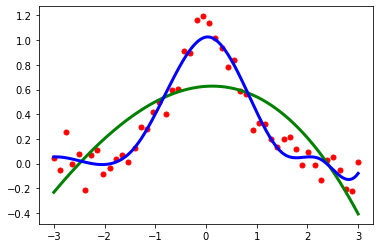

In [2]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.UnivariateSpline.html

x = np.linspace(-3, 3, 50)
y = np.exp(-x**2) + 0.1 * np.random.randn(50)
plt.plot(x, y, 'ro', ms=5)

spl = UnivariateSpline(x, y)
xs = np.linspace(-3, 3, 1000)
plt.plot(xs, spl(xs), 'g', lw=3)
spl.set_smoothing_factor(0.5)
plt.plot(xs, spl(xs), 'b', lw=3)
plt.show()

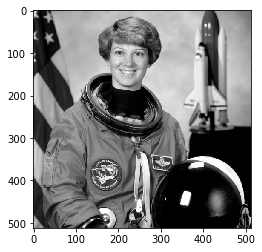

In [3]:
# make dots with 
# starting coordinate
# initial growing direction
# wiggleness function

from skimage import data
from skimage import color
from skimage import io

img = getattr(data,'astronaut')()
img = color.rgb2gray(img)

plt.imshow(img,cmap='gray')

In [43]:
# hack method to create an image containing one squiggly line.
def make_randome_line(actualmaxx=512):
    num=30
    # start point
    grow = np.random.choice(['x','y']) # <--- change start growing axis
    inverse = np.random.choice([False,True]) # <--- change start growing axis
    val = np.random.randint(10,actualmaxx-10,1)[0]
    myy=[val] # <--- change pos on growing axis
    myx=[0]
    # max end point
    maxx = np.random.randint(100,actualmaxx,1)[0]
    miny = np.random.randint(10,myy[0],1)[0]
    maxy = np.random.randint(myy[0],512,1)[0]

    create=True
    ind = 0
    loopcount = 0
    while create:
        interval_x = np.random.randint(1,50,1)[0]
        interval_y = np.random.randint(-200,200,1)[0]
        newx = myx[ind-1]+interval_x
        newy = myy[ind-1]+interval_y
        loopcount+=1
        if loopcount > 100:
            break
        if newx < 0 or newx >= maxx:
            continue
        if newy < miny or newy >= maxy:
            continue
        myx.append(newx)
        myy.append(newy)
        ind = len(myx)
        if ind > 20:
            create=False

    spl = UnivariateSpline(myx,myy)

    xs = np.linspace(np.min(myx),np.max(myx), 1000)
    sm = np.random.randint(900000,1000000,1)[0]
    spl.set_smoothing_factor(sm)
    ys = spl(xs)

    canvas = np.zeros(img.shape)
    _xs = np.array(xs)
    _ys = np.array(ys)
    if inverse:
       _xs = np.abs(actualmaxx-_xs) 
    if grow == 'x':
        xs=[int(x) for x in _xs]
        ys=[int(x) for x in _ys]
    else:
        xs=[int(x) for x in _ys]
        ys=[int(x) for x in _xs]

    for x,y in zip(xs,ys):
        x = int(x)
        y = int(y)
        if x not in list(range(img.shape[0])) or \
           y not in list(range(img.shape[1])):
            continue    
        canvas[x,y]=1
    print('direction:',grow,'inverse:',inverse,'start: (',xs[0],ys[0],')','end:(',xs[-1],ys[-1],')')
    canvas = binary_dilation(canvas,iterations=1)

    return canvas,xs,ys

direction: x inverse: True start: ( 512 425 ) end:( 64 366 )


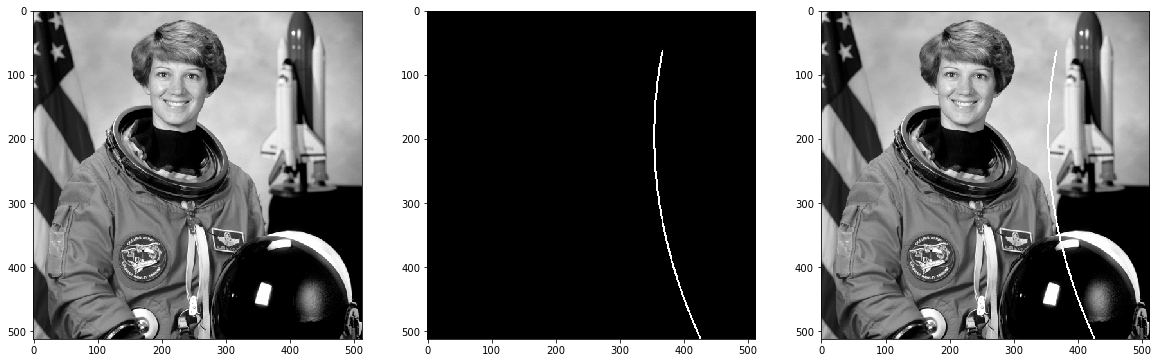

In [89]:
canvas,xs,ys=make_randome_line()
plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow(img,cmap='gray')
plt.subplot(132)
plt.imshow(canvas,cmap='gray')
plt.subplot(133)
tmp = np.array(img)
tmp[canvas==True]=1
plt.imshow(tmp,cmap='gray')